# Introdução ao Projeto de Classificação de Imagens de Câncer de Mama

Este documento apresenta uma introdução ao projeto de análise e classificação de imagens médicas, focado na detecção de câncer de mama utilizando o dataset BreastMNIST. O projeto emprega uma combinação de técnicas de Machine Learning e Algoritmos Genéticos para otimizar o processo de classificação.

## Visão Geral do Código

O codig implementa um fluxo de trabalho completo para a classificação de imagens de câncer de mama. As principais etapas incluem:

1.  **Carregamento e Pré-processamento de Dados**: Utilização da biblioteca `MedMNIST` para acessar o dataset BreastMNIST, que consiste em imagens de ultrassom de mama. Os dados são carregados e preparados para o treinamento de modelos, incluindo transformações necessárias para redes neurais.
2.  **Modelagem com Machine Learning**: Aplicação de algoritmos de Machine Learning, como Regressão Logística, para estabelecer uma linha de base de desempenho na classificação das imagens.
3.  **Otimização com Algoritmos Genéticos**: Integração da biblioteca `DEAP` para implementar Algoritmos Genéticos. Esta abordagem é utilizada para otimizar parâmetros de modelos ou características, buscando melhorar a acurácia e outras métricas de desempenho da classificação.
4.  **Avaliação de Desempenho**: O código inclui métricas de avaliação como acurácia, precisão, recall, F1-score e AUC-ROC para quantificar a eficácia dos modelos desenvolvidos.

O objetivo principal é demonstrar como a combinação de técnicas tradicionais de Machine Learning com a otimização meta-heurística de Algoritmos Genéticos pode ser aplicada em problemas de classificação de imagens médicas, visando aprimorar a capacidade preditiva e a robustez dos modelos.

*   **Autor**: Flavio Tamaki
*   **E-mail**: flaviotamaki@gmail.com


O Bloco abaixo é para carregar todas as bibliotécas necessárias 


Tentando usar o modelo: models/gemini-2.5-flash
Using downloaded and verified file: ./data\breastmnist.npz
Using downloaded and verified file: ./data\breastmnist.npz

--- Minhas Informações do Dataset BREASTMNIST ---
Número de canais: 1
Número de classes: 2
Classes: {'0': 'malignant', '1': 'normal, benign'}

Dataset de Treino: 546 amostras
Formato de uma amostra de treino (imem, label): torch.Size([1, 28, 28]), (1,)


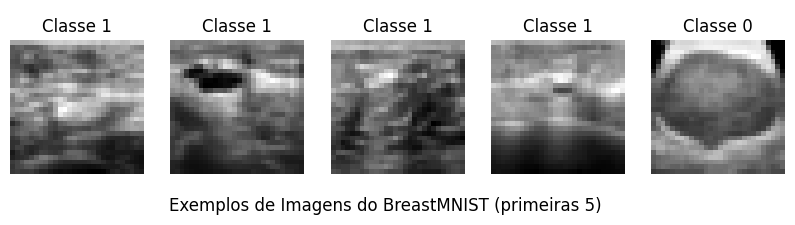


Dataset de Teste: 156 amostras
Formato de uma amostra de teste (imem, label): torch.Size([1, 28, 28]), (1,)

Dataset BreastMNIST carregado e pronto para uso!


In [54]:
# Vou usar o MedMNIST para o BreastMNIST, que é de câncer de mama por imagem.
import medmnist
from medmnist import INFO 
import numpy as np                          # arrays multidimensionais e operações matemáticas
import torch                                # Biblioteca para deep learning com GPU e tensores eficientes.
import torchvision.transforms as transforms # Módulo para aplicar transformações em imagens no PyTorch
import matplotlib.pyplot as plt             # Biblioteca para criar gráficos e visualizações
import os                                   # Importar a biblioteca os para criar diretórios
import seaborn as sns                       # Biblioteca para visualização de dados baseada no matplotlib
import pandas as pd                         # Biblioteca para manipulação e análise de dados

# scikit-learn para pré-processamento, modelagem e avaliação de modelos de machine learning, incluindo algoritmos genéticos
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold   # Divisão de dados e validação cruzada
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder                    # Pré-processamento de dados, incluindo normalização e codificação
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  # Métricas de avaliação de modelos, incluindo AUC-ROC 
from sklearn.linear_model import LogisticRegression                                                 # Regressão Logística, um modelo de classificação básico 

# Para Algoritmos Genéticos (DEAP) | Distributed Evolutionary Algorithms in Python 
from deap import base, creator, tools, algorithms # Framework para Algoritmos Evolutivos, incluindo Algoritmos Genéticos 
import random                                     # Biblioteca para geração de números aleatórios, usada em Algoritmos Genéticos

#importanto o dotenv para carregar variáveis de ambiente, chave de API do Google
from dotenv import load_dotenv  # Carregar variáveis de ambiente de um arquivo .env
load_dotenv()                   # Carrega as variáveis do arquivo .env para o ambiente

# Para Google Gemini (LLM) e acesso a segredos do Colab
import google.generativeai as genai # Biblioteca para interagir com os modelos de linguagem do Google Gemini
import os                           # Biblioteca para acessar variáveis de ambiente

# Obtém a chave do arquivo .env
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")        
if not GOOGLE_API_KEY:
    raise ValueError("A variável GOOGLE_API_KEY não foi encontrada no arquivo .env")
genai.configure(api_key=GOOGLE_API_KEY)

# Teste de integração com o Gemini
model_name_to_use = "models/gemini-2.5-flash"  # Pode ser "models/gemini-1.5-pro" ou "models/gemini-2.5-flash"
print(f"\nTentando usar o modelo: {model_name_to_use}") 

# Vou definir qual dataset quero usar e se é 2D ou 3D.
# O BreastMNIST é 2D com imagens de 28x28 pixels em escala de cinza.
DATA_FLAG = 'breastmnist'   # Dataset de câncer de mama
DOWNLOAD_ROOT = './data'    # Diretório onde os dados serão baixados

# Criar o diretório de download se ele não existir
if not os.path.exists(DOWNLOAD_ROOT):
    os.makedirs(DOWNLOAD_ROOT)
    print(f"Diretório '{DOWNLOAD_ROOT}' criado com sucesso!")


# Preciso de transformações para preparar as imagens para o modelo.
# Redimensionar para 28x28 (padrão do MedMNIST) e converter para tensor.
# A normalização é importante para redes neurais.
# O MedMNIST já fornece as estatísticas de normalização para cada dataset.

data_transform = transforms.Compose([           # Composição de várias transformações
    transforms.ToTensor(),                      # Converte a imagem PIL para um tensor PyTorch (0-1)
    transforms.Normalize(mean=[.5], std=[.5])   # Normalização padrão para MedMNIST
])

# Vou carregar as informações do dataset para entender melhor.
info = INFO[DATA_FLAG]              # Obtém as informações do dataset
n_channels = info['n_channels']     # Número de canais (1 para grayscale, 3 para RGB)
n_classes = len(info['label'])      # Número de classes (labels) no dataset

# Algorítimo Genéticoora vou carregar os datasets de treino e teste.
# O MedMNIST facilita isso com as classes Dataset.

DataClass = getattr(medmnist, info['python_class']) # Obtém a classe do dataset dinamicamente, ex: medmnist.BreastMNIST

train_dataset = DataClass(split='train', transform=data_transform, download=True, root=DOWNLOAD_ROOT)   # Dataset de treino, com transformações aplicadas e baixado se necessário
test_dataset = DataClass(split='test', transform=data_transform, download=True, root=DOWNLOAD_ROOT)     # Dataset de teste, com transformações aplicadas e baixado se necessário

# Quero ver quantos exemplos tenho e qual o formato das imAlgorítimo Genéticoens.
print(f"\n--- Minhas Informações do Dataset {DATA_FLAG.upper()} ---")   # DATA_FLAG é 'breastmnist'
print(f"Número de canais: {n_channels}")                                # 1 para grayscale, 3 para RGB, etc.
print(f"Número de classes: {n_classes}")                                # Número de classes (labels)
print(f"Classes: {info['label']}")                                      # Dicionário de classes, ex: {0: 'normal', 1: 'benign', 2: 'malignant'} Parte importante para Algoritmos Genéticos

print(f"\nDataset de Treino: {len(train_dataset)} amostras")            # Número de amostras no dataset de treino
print(f"Formato de uma amostra de treino (imem, label): {train_dataset[0][0].shape}, {train_dataset[0][1].shape}") # Formato da primeira amostra (imagem, label)

# Visualizar mais 5 imagens do dataset de treino
fig, axes = plt.subplots(1, 5, figsize=(10, 2)) # 1 linha, 5 colunas
for i in range(5):
    img, lbl = train_dataset[i]
    img_disp = img.numpy().squeeze()
    axes[i].imshow(img_disp, cmap='gray')
    axes[i].set_title(f"Classe {lbl.item()}")
    axes[i].axis('off')
plt.suptitle("\n\n\n\n\n\n\n\n\nExemplos de Imagens do BreastMNIST (primeiras 5)")
plt.show()

print(f"\nDataset de Teste: {len(test_dataset)} amostras")
print(f"Formato de uma amostra de teste (imem, label): {test_dataset[0][0].shape}, {test_dataset[0][1].shape}")

# Posso até visualizar uma imagem para ter uma ideia se carregou certo.
# Vou pegar a primeira imagem do dataset de treino e mostrar.

print("\nDataset BreastMNIST carregado e pronto para uso!")

## Preparação do Dataset BreastMNIST para Modelagem de Machine Learning

Com o dataset BreastMNIST devidamente carregado, a próxima etapa é a **preparação** para a modelagem de Machine Learning. Esta fase garanti que os dados estejam no formato e escala corretos, otimizando o desempenho e a estabilidade dos algoritmos de ML.

### Etapas Essenciais de Pré-processamento:

1.  **Normalização/Escalonamento**: As imagens, representadas por valores de pixel, serão normalizadas para um intervalo padrão (e.g., 0-1 ou média 0 e desvio padrão 1). para evitar que características com maiores magnitudes dominem o processo de treinamento e para acelerar a convergência de muitos algoritmos.
2.  **Divisão em Conjuntos de Treino e Teste**: O dataset será dividido em conjuntos de treino e teste. O conjunto de treino será utilizado para ensinar o modelo, enquanto o conjunto de teste, composto por dados não vistos, servirá para avaliar a capacidade de generalização do modelo de forma imparcial.
3.  **Transformações Específicas**: Dependendo do modelo de ML a ser empregado (por exemplo, redes neurais convolucionais), podem ser necessárias transformações adicionais, como redimensionamento ou alteração da estrutura dos tensores das imagens.
4.  **Codificação de Rótulos**: Os rótulos das classes (maligno/benigno) serão codificados numericamente, se ainda não estiverem, para serem compatíveis com os requisitos dos algoritmos de Machine Learning.

O objetivo desta seção é transformar os dados brutos do BreastMNIST em um formato limpo e estruturado, pronto para ser consumido pelos modelos de Machine Learning e Algoritmos Genéticos, garantindo assim uma base sólida para a análise e otimização subsequentes.


In [55]:
# Vou converter os datasets do formato PyTorch para arrays NumPy, que o scikit-learn entende.

# Função auxiliar para converter o dataset PyTorch para NumPy arrays
def convert_dataset_to_numpy(dataset):
    images = []
    labels = []
    for img, label in dataset:
        images.append(img.numpy()) # Converte o tensor da imagem para numpy
        labels.append(label.item()) # Pega o valor escalar do tensor do label
    return np.array(images), np.array(labels)

# Convertendo os datasets de treino e teste
X_train_raw, y_train = convert_dataset_to_numpy(train_dataset)  # explicando X_train_raw é o array bruto de imagens, y_train são os labels
X_test_raw, y_test = convert_dataset_to_numpy(test_dataset)     # explicando X_test_raw é o array bruto de imagens, y_test são os labels

# As imagens estão em formato (1, 28, 28) (canal, altura, largura).
# Para a maioria dos modelos de scikit-learn, preciso "achatar" (flatten) a imagem para um vetor 1D.
# O formato final será (número_de_amostras, 784), onde 784 = 28 * 28.

X_train = X_train_raw.reshape(X_train_raw.shape[0], -1) # Explicando: Achata para (n_amostras, 784) ou seja (n_amostras, 28*28) para treino
X_test = X_test_raw.reshape(X_test_raw.shape[0], -1)    # Explicando: Achata para (n_amostras, 784) ou seja (n_amostras, 28*28) para teste

# Agora os dados estão prontos. Vou definir um modelo de classificação base.
# Uma Regressão Logística é um bom ponto de partida por ser simples e interpretável.

# Instanciando o modelo base. Vou usar um solver robusto e aumentar o max_iter para convergência.
# random_state para reprodutibilidade.
model_base = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42) # logisticRegression é um modelo simples e eficiente para classificação, nesse caso de imagens pequenas como 28x28.

# Vou treinar o modelo base com meus dados de treino.
print("\nTreinando o modelo base (Regressão Logística)...")
model_base.fit(X_train, y_train)        # Treinamento do modelo utilizando os dados de treino, essa linha realiza o ajuste do modelo aos dados 
print("Treinamento do modelo base concluído.")

# Agora vou avaliar o desempenho do modelo base nos dados de teste.
# Isso me dará uma linha de base para comparar com os modelos otimizados pelo Algorítimo Genético .

y_pred_base = model_base.predict(X_test) # Fazendo previsões com o modelo treinado nos dados de teste

# A metrica Recall é crucial em datasets desbalanceados, como o BreastMNIST (3 classes, mas 2 são raras), pois foca em minimizar falsos negativos.
# minimizar falsos negativos é vital em detecção de câncer, onde perder um caso positivo pode ter consequências graves.
# dessa forma, o modelo base já me dá uma ideia de como o modelo simples se comporta.
accuracy_base = accuracy_score(y_test, y_pred_base)                         # Acurácia: proporção de previsões corretas (0 a 1, 1 = perfeito)
precision_base = precision_score(y_test, y_pred_base, average='weighted')   # Precisão ponderada: acerto entre previsões positivas, considerando desequilíbrio de classes
recall_base = recall_score(y_test, y_pred_base, average='weighted')         # Recall ponderado: capacidade de identificar corretamente todas as amostras de cada classe
f1_base = f1_score(y_test, y_pred_base, average='weighted')                 # F1-score ponderado: média harmônica entre precisão e recall

# AUC-ROC é mais complexo em multiclasse. Vou usar o método one-vs-rest (ovr) e a média ponderada.
# método one-vs-rest (ovr) cria um classificador binário para cada classe contra todas as outras. exemplo: para 3 classes A, B, C, cria 3 classificadores: A vs (B,C), B vs (A,C), C vs (A,B).
# Para LogisticRegression, preciso do método predict_proba
if hasattr(model_base, "predict_proba"):                # Verifica se o modelo tem o método predict_proba
    y_proba_base = model_base.predict_proba(X_test)     # Obtém as probabilidades previstas para cada classe
    auc_roc_base = roc_auc_score(y_test, y_proba_base[:, 1], multi_class='ovr', average='weighted') # AUC-ROC ponderado usando o método one-vs-rest

else:
    auc_roc_base = "N/A (modelo não suporta predict_proba)" # Caso o modelo não suporte predict_proba, AUC-ROC não pode ser calculado

print("\n--- Desempenho do Modelo Base (Regressão Logística) ---")
print(f"Accuracy: {accuracy_base:.4f}")
print(f"Precision (weighted): {precision_base:.4f}")
print(f"Recall (weighted): {recall_base:.4f}")
print(f"F1-Score (weighted): {f1_base:.4f}")
print(f"AUC-ROC (weighted, ovr): {auc_roc_base}")

print("\nModelo base estabelecido. Agora tenho uma referência para a otimização com Algoritmos Genéticos!")


Treinando o modelo base (Regressão Logística)...
Treinamento do modelo base concluído.

--- Desempenho do Modelo Base (Regressão Logística) ---
Accuracy: 0.7949
Precision (weighted): 0.7837
Recall (weighted): 0.7949
F1-Score (weighted): 0.7853
AUC-ROC (weighted, ovr): 0.8233082706766917

Modelo base estabelecido. Agora tenho uma referência para a otimização com Algoritmos Genéticos!


### Análise dos Resultados do Modelo

**Accuracy: 0.7949 (~79,5%)**  
- Aproximadamente 80% das previsões estão corretas.  
- Boa indicação geral, mas não leva em conta o desequilíbrio entre classes.

**Precision (weighted): 0.7837 (~78,4%)**  
- Proporção de previsões positivas corretas, ponderada pelo tamanho das classes.  
- Quando o modelo prevê maligno ou benigno, acerta ~78% das vezes.

**Recall (weighted): 0.7949 (~79,5%)**  
- Capacidade de capturar corretamente todas as amostras reais de cada classe.  
- Importante para não deixar casos malignos passarem despercebidos.  
- Valor de ~79,5% indica que a maioria das amostras está sendo identificada corretamente.

**F1-Score (weighted): 0.7853 (~78,5%)**  
- Média harmônica entre precisão e recall.  
- Indica bom equilíbrio entre acertos e cobertura das classes.

**AUC-ROC (weighted, ovr): 0.8233 (~82,3%)**  
- Mede a capacidade do modelo de separar classes (maligno vs benigno).  
- Valor > 0.8 é considerado bom, mostrando que o modelo diferencia bem as classes.

**Resumo:**  
- O modelo apresenta desempenho sólido, com boa capacidade de classificação e separação das classes.  
- Recall relativamente alto é positivo para detecção de câncer, reduzindo falsos negativos.  
- Há espaço para melhorar a precisão, diminuindo falsos positivos, se necessário.


## Configuração do Modelo Base e Otimização de Hiperparâmetros com Algoritmos Genéticos

Após a preparação do dataset BreastMNIST, o próximo passo é a **configuração de um modelo base** e a subsequente **otimização de seus hiperparâmetros** utilizando Algoritmos Genéticos. Esta abordagem visa não apenas estabelecer uma referência de desempenho, mas também aprimorar a capacidade preditiva do modelo de forma sistemática.

### 1. Estabelecimento do Modelo Base

Um **modelo base** serve como um ponto de partida e uma referência para avaliar a eficácia de otimizações futuras. Para a classificação de imagens médicas, um modelo simples, mas robusto, como a **Regressão Logística** ou uma **Rede Neural Convolucional (CNN) básica**, pode ser empregado inicialmente. Os passos para a configuração do modelo base incluem:

*   **Seleção do Algoritmo**: Escolha de um algoritmo de Machine Learning que seja adequado para a tarefa de classificação binária de imagens.
*   **Treinamento Inicial**: O modelo será treinado com os dados de treino pré-processados, utilizando um conjunto inicial de hiperparâmetros (muitas vezes, os valores padrão do algoritmo).
*   **Avaliação de Desempenho**: O desempenho do modelo base será avaliado utilizando métricas como acurácia, precisão, recall, F1-score e AUC-ROC no conjunto de teste. Este resultado inicial será o *baseline* a ser superado.

### 2. Otimização de Hiperparâmetros com Algoritmos Genéticos

A performance de um modelo de Machine Learning é fortemente influenciada por seus **hiperparâmetros**, que são configurações externas ao modelo e não são aprendidas diretamente dos dados. A busca manual por esses valores ótimos é ineficiente e muitas vezes inviável. É aqui que os **Algoritmos Genéticos (AGs)** se destacam como uma poderosa ferramenta de otimização meta-heurística.

Os AGs, inspirados na seleção natural e na genética, exploram um espaço de busca complexo para encontrar combinações de hiperparâmetros que maximizem a performance do modelo. A implementação envolverá as seguintes etapas:

*   **Definição do Espaço de Busca**: Especificação dos intervalos e tipos de valores para cada hiperparâmetro a ser otimizado (e.g., taxa de aprendizado, número de camadas, tamanho do batch, regularização).
*   **Codificação (Cromossomos)**: Cada conjunto de hiperparâmetros será representado como um "cromossomo" (uma sequência de genes), permitindo que o AG manipule essas configurações.
*   **Função de Aptidão (Fitness Function)**: Uma função será definida para avaliar a "qualidade" de cada cromossomo. Geralmente, esta função envolve treinar o modelo com os hiperparâmetros codificados e retornar uma métrica de desempenho (e.g., acurácia de validação, AUC-ROC) que o AG tentará maximizar.
*   **Operadores Genéticos**: Aplicação de operadores como **seleção**, **cruzamento (crossover)** e **mutação** para gerar novas gerações de cromossomos (conjuntos de hiperparâmetros). Estes operadores permitem a exploração e explotação do espaço de busca.
*   **Critério de Parada**: Definição de condições para encerrar o processo de otimização, como um número máximo de gerações ou a estabilização da função de aptidão.

Ao final deste processo, o Algoritmo Genético terá identificado uma combinação de hiperparâmetros que, idealmente, resultará em um modelo com desempenho superior ao baseline, demonstrando o poder da otimização evolutiva em problemas de Machine Learning.


In [56]:
# Cada indivíduo será uma lista de hiperparâmetros para a Regressão Logística.
# Vou otimizar: C (força de regularização), solver e penalty.

# Definição dos hiperparâmetros e seus ranges/opções, aqui é onde o Algoritmo Genético vai atuar.
# C é float log-uniforme entre 0.001 e 100
# solver é categórico entre 'liblinear' e 'saga' (bons para datasets pequenos e médios)
# penalty é categórico entre 'l1' e 'l2'
# Note que algumas combinações de solver/penalty não são válidas no sklearn, vou tratar isso na função fitness.
hyperparameter_space = {
    'C': {'type': 'float', 'min': 0.001, 'max': 100.0, 'scale': 'log'},     # C é um float log-uniforme entre 0.001 e 100
    'solver': {'type': 'categorical', 'options': ['liblinear', 'saga']},    # solver é categórico entre 'liblinear' e 'saga'
    'penalty': {'type': 'categorical', 'options': ['l1', 'l2']}             # penalty é categórico, l1 quer dizer regularização Lasso e l2 é Ridge
}

# Preciso criar os tipos para o indivíduo e a função fitness.
creator.create("FitnessMax", base.Fitness, weights=(1.0,))      # FitnessMax significa que quero maximizar a função fitness (F1-score), ou seja quanto maior o F1-score, melhor
creator.create("Individual", list, fitness=creator.FitnessMax)  # Individual é uma lista que conterá os valores dos hiperparâmetros, ou seja [C, solver, penalty] 

# Agora vou configurar o toolbox da DEAP.
# O toolbox contém as funções para gerar indivíduos, população, e os operadores genéticos.
toolbox = base.Toolbox() # Inicializa o toolbox do DEAP, que armazenará as funções e operadores para o Algoritmo Genético

# Função para gerar um hiperparâmetro aleatório com base no espaço definido
def generate_hyperparameter(param_name):                # Gera um valor aleatório para o hiperparâmetro especificado
    param_info = hyperparameter_space[param_name]       # Obtém as informações do hiperparâmetro do espaço definido
    if param_info['type'] == 'float':                   # Se o tipo for float
        if param_info['scale'] == 'log':                # log significa que quero uma distribuição log-uniforme quer dizer valores mais baixos são mais prováveis
            return np.exp(random.uniform(np.log(param_info['min']), np.log(param_info['max']))) # Gera um float log-uniforme entre min e max
        else:
            return random.uniform(param_info['min'], param_info['max'])
    elif param_info['type'] == 'categorical':
        return random.choice(param_info['options'])     # Escolhe aleatoriamente uma das opções categóricas

# Vou registrar a função para criar um indivíduo.
# Um indivíduo será uma lista com os valores de C, solver e penalty.
# A ordem é importante aqui.
toolbox.register("attr_C", generate_hyperparameter, 'C')                # Registra a função para gerar o hiperparâmetro C
toolbox.register("attr_solver", generate_hyperparameter, 'solver')      # Registra a função para gerar o hiperparâmetro solver
toolbox.register("attr_penalty", generate_hyperparameter, 'penalty')    # Registra a função para gerar o hiperparâmetro penalty

toolbox.register("individual", tools.initCycle, creator.Individual,                 # Registra a função para criar um indivíduo
                 (toolbox.attr_C, toolbox.attr_solver, toolbox.attr_penalty), n=1)  # Cada indivíduo terá um valor de C, solver e penalty, n=1 significa que quero um conjunto único de hiperparâmetros por indivíduo

# Como a população é composta por indivíduos.
toolbox.register("population", tools.initRepeat, list, toolbox.individual) # Registra a função para criar uma população de indivíduos, que é uma lista de indivíduos

# Esta é a função mais importante: a função fitness.
# Ela pega um indivíduo (conjunto de hiperparâmetros), treina um modelo e retorna sua performance.
# Vou usar validação cruzada estratificada para uma avaliação mais robusta.

def evaluate_individual(individual): # Função para avaliar a fitness de um indivíduo (conjunto de hiperparâmetros)
    # O indivíduo é uma lista [C, solver, penalty].
    C_val = individual[0]           # Valor de C do indivíduo
    solver_val = individual[1]      # Valor de solver do indivíduo
    penalty_val = individual[2]     # Valor de penalty do indivíduo

    # Algumas combinações de solver/penalty não são válidas no sklearn
    # Preciso tratar isso para evitar erros e penalizar indivíduos inválidos
    if solver_val == 'liblinear' and penalty_val == 'elasticnet':   # liblinear não suporta elasticnet
        return 0.0,                                                 # Retorno 0.0 para fitness inválida
    if solver_val in ['lbfgs', 'newton-cg', 'sag', 'saga'] and penalty_val == 'l1': # lbfgs, newton-cg e sag não suportam l1
        return 0.0,                                                 # Retorno 0.0 para fitness inválida     
        if solver_val != 'saga':                                    # Apenas saga suporta l1 com esses solvers
            return 0.0,                                             # Retorno 0.0 para fitness inválida
    if solver_val in ['lbfgs', 'newton-cg', 'sag'] and penalty_val == 'elasticnet': # lbfgs, newton-cg e sag não suportam elasticnet
        return 0.0,                                                 # Retorno 0.0 para fitness inválida

    # Instancio o modelo com os hiperparâmetros do indivíduo.
    # random_state para reprodutibilidade do modelo interno.
    model = LogisticRegression(C=C_val, solver=solver_val, penalty=penalty_val, 
                               max_iter=1000, random_state=42, multi_class='ovr')   # multi_class='ovr' para lidar com múltiplas classes, ovr = one-vs-rest que é bom para datasets pequenos e médios

    # Vou usar validação cruzada estratificada para avaliar o modelo.
    # Isso me dá uma estimativa mais confiável do desempenho.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Validação cruzada estratificada com 5 folds, folds são subconjuntos do dataset que mantêm a proporção das classes

    # Calculo o F1-score ponderado médio da validação cruzada.
    # X_train e y_train são os dados de treino que preparei no bloco anterior.
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1) # Usando F1-score ponderado para lidar com classes desbalanceadas

    # A fitness é a média dos scores da validação cruzada.
    return np.mean(scores),

toolbox.register("evaluate", evaluate_individual) # Registra a função de avaliação no toolbox

# Defino os operadores genéticos.
# Cruzamento (crossover): tools.cxUniform para misturar os hiperparâmetros.
# Mutação: tools.mutGaussian para floats, tools.mutShuffleIndexes para categóricos (preciso adaptar).
# Para este exemplo, vou usar cxUniform e mutFlipBit para simplificar a demonstração.
# Para hiperparâmetros categóricos, mutação é mais complexa. Vou usar uma abordagem simples por enquanto.

# Para o crossover, vou usar um crossover de dois pontos para manter a estrutura do indivíduo.
toolbox.register("mate", tools.cxTwoPoint) # Registra o operador de cruzamento de dois pontos

# Para a mutação, preciso de algo que respeite os tipos de hiperparâmetros.
# Vou criar uma função de mutação customizada para lidar com floats e categóricos.
def custom_mutate(individual, indpb, hyperparameter_space):                         # Função de mutação customizada que respeita os tipos de hiperparâmetros
    for i, param_name in enumerate(hyperparameter_space.keys()):    
        if random.random() < indpb:                                                 # indpb é a probabilidade de mutação por gene
            param_info = hyperparameter_space[param_name]                           # Obtém as informações do hiperparâmetro
            if param_info['type'] == 'float':   
                # Mutação gaussiana para floats
                individual[i] = np.exp(random.gauss(np.log(individual[i]), 0.5))    # Variação logarítmica, ou seja, valores menores têm mais variação
                individual[i] = max(param_info['min'], min(param_info['max'], individual[i])) # Garante os limites
            elif param_info['type'] == 'categorical':
                # Mutação escolhendo uma nova opção aleatória
                original_option = individual[i]                                     # Armazena a opção original para evitar escolher a mesma
                available_options = [opt for opt in param_info['options'] if opt != original_option] # Filtra as opções disponíveis
                if available_options:                                               # Se houver outras opções para escolher
                    individual[i] = random.choice(available_options) 
    return individual,

# A linha abaixo registra a função de mutação customizada no toolbox.
# indpb=0.1 significa que cada gene (hiperparâmetro) tem 10% de chance de ser mutado.
toolbox.register("mutate", custom_mutate, indpb=0.1, hyperparameter_space=hyperparameter_space) 

# E a seleção dos indivíduos para a próxima geração.
toolbox.register("select", tools.selTournament, tournsize=3)

print("\nAlgoritmo Genético configurado com sucesso para otimização de hiperparâmetros!")
print("Pronto para rodar o Algoritimo Genético e encontrar os melhores hiperparâmetros para o modelo de diagnóstico.")


Algoritmo Genético configurado com sucesso para otimização de hiperparâmetros!
Pronto para rodar o Algoritimo Genético e encontrar os melhores hiperparâmetros para o modelo de diagnóstico.


c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


## Execução do Algoritmo Genético para Otimização de Hiperparâmetros

Com o Algoritmo Genético (AG) configurado com sucesso, o processo de otimização será iniciado. Esta etapa crucial envolve:

*   **Exploração Sistemática**: O AG explorará o espaço de hiperparâmetros do modelo de diagnóstico de forma sistemática.
*   **Múltiplas Gerações**: Através de diversas gerações, o AG aplicará operadores genéticos como seleção, cruzamento e mutação.
*   **Identificação de Combinações Ótimas**: O objetivo é encontrar as combinações de hiperparâmetros que maximizam a performance do modelo.
*   **Melhoria da Performance**: A meta final é convergir para um conjunto de configurações que proporcionem a melhor acurácia e capacidade de generalização, elevando a eficácia do sistema de classificação de imagens de câncer de mama.



Iniciando a otimização de hiperparâmetros com Algoritmos Genéticos...
gen	nevals	avg     	std     	min	max     
0  	100   	0.489412	0.345496	0  	0.784938
1  	76    	0.723664	0.148874	0  	0.786633
2  	79    	0.766312	0.0777194	0  	0.786633
3  	78    	0.772232	0.0779051	0  	0.788202
4  	87    	0.752315	0.153641 	0  	0.788202
5  	68    	0.770752	0.110121 	0  	0.788202
6  	80    	0.779015	0.0784077	0  	0.788202
Otimização de hiperparâmetros concluída!

--- Melhor Indivíduo Encontrado pelo Algorítimo Genético ---
Hiperparâmetros Otimizados:
  C: 2.954319
  Solver: saga
  Penalty: l2
Fitness (F1-Score ponderado): 0.7882


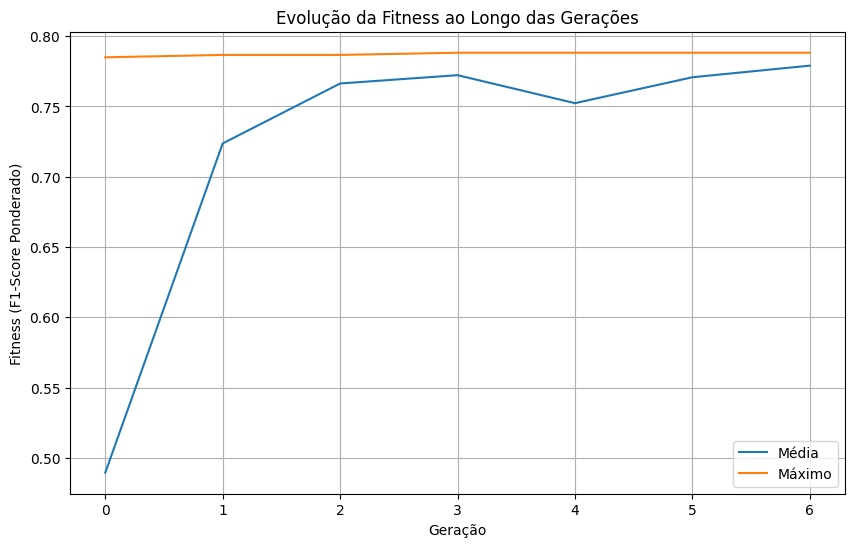


Próximo passo: Treinar o modelo com os hiperparâmetros otimizados e comparar com o modelo base!


In [57]:
# Agora que o Algorítimo Genético está configurado, é hora rodar
# Preciso definir os parâmetros da minha simulação genética.

POPULATION_SIZE = 100   # Quantos indivíduos (conjuntos de hiperparâmetros) terei em cada geração.
N_GENERATIONS = 6       # Quantas gerações o Algorítimo Genético vai evoluir.
CXPB = 0.7              # Probabilidade de ocorrer cruzamento (crossover).
MUTPB = 0.2             # Probabilidade de ocorrer mutação.

# Vou criar a população inicial de indivíduos.
population = toolbox.population(n=POPULATION_SIZE)

# Preciso de um objeto para coletar estatísticas durante a evolução.
# Isso me ajuda a monitorar o progresso do AG.
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)  # Média da fitness na população
stats.register("std", np.std)   # Desvio padrão da fitness na população
stats.register("min", np.min)   # Mínimo da fitness na população
stats.register("max", np.max)   # Máximo da fitness na população

# Também quero registrar o melhor indivíduo de cada geração.
# Isso é útil para ver como o melhor desempenho evolui.
halloffame = tools.HallOfFame(1) # Vou guardar apenas o melhor indivíduo de todos os tempos.

# Agora, vou rodar o algoritmo genético principal.
# O eaSimple é um algoritmo genético básico que implementa o ciclo de evolução.
print("\nIniciando a otimização de hiperparâmetros com Algoritmos Genéticos...")
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB,  # Executa o Algoritmo Genético com os parâmetros definidos
                                        ngen=N_GENERATIONS, stats=stats, halloffame=halloffame, # Registra o melhor indivíduo encontrado
                                        verbose=True) # verbose=True para imprimir o progresso no console

print("Otimização de hiperparâmetros concluída!")

# Depois de rodar o AG, quero ver qual foi o melhor indivíduo encontrado.
# O halloffame guarda o melhor.
best_individual = halloffame[0]                     # Melhor indivíduo encontrado pelo Algoritmo Genético, esse indivíduo contém os melhores hiperparâmetros
best_fitness = best_individual.fitness.values[0]    # Fitness do melhor indivíduo, ou seja o F1-score ponderado correspondente a esses hiperparâmetros

# Vou extrair os hiperparâmetros do melhor indivíduo.
# Lembre-se da ordem: C, solver, penalty.
optimized_C = best_individual[0]                    # Valor otimizado de C, C representa a força da regularização do modelo
optimized_solver = best_individual[1]               # Valor otimizado do solver, solver é o algoritmo usado para otimizar a função de custo
optimized_penalty = best_individual[2]              # Valor otimizado do penalty, penalty é o tipo de regularização aplicada (L1 ou L2)

print("\n--- Melhor Indivíduo Encontrado pelo Algorítimo Genético ---")
print(f"Hiperparâmetros Otimizados:")
print(f"  C: {optimized_C:.6f}")
print(f"  Solver: {optimized_solver}")
print(f"  Penalty: {optimized_penalty}")
print(f"Fitness (F1-Score ponderado): {best_fitness:.4f}")

# Posso também plotar a evolução da fitness ao longo das gerações.
# Isso me ajuda a visualizar se o Algorítimo Genético convergiu, convergiu significa que encontrou uma solução estável.
# Vou usar o logbook que foi preenchido durante a execução do AG.
# logbook é um objeto que armazena estatísticas da evolução, como média, máximo, etc.

gen, avg, std, min_val, max_val = logbook.select("gen", "avg", "std", "min", "max") # Extrai os dados do logbook para plotagem
plt.figure(figsize=(10, 6))                             # Define o tamanho da figura        
plt.plot(gen, avg, label="Média")                       # Plota a média da fitness ao longo das gerações
plt.plot(gen, max_val, label="Máximo")                  # Plota o máximo da fitness ao longo das gerações
plt.xlabel("Geração")                                   # Rótulo do eixo x  
plt.ylabel("Fitness (F1-Score Ponderado)")              # Rótulo do eixo y
plt.title("Evolução da Fitness ao Longo das Gerações")  # Título do gráfico
plt.legend()                                            # Adiciona a legenda ao gráfico                      
plt.grid(True)                                          # Adiciona uma grade ao gráfico            
plt.show()                                              # Exibe o gráfico

print("\nPróximo passo: Treinar o modelo com os hiperparâmetros otimizados e comparar com o modelo base!")


Iniciando a otimização de hiperparâmetros com Algoritmos Genéticos...
gen	nevals	avg     	std     	min	max     
0  	100   	0.507581	0.343571	0  	0.789757
1  	81    	0.712357	0.184337	0  	0.789757
2  	73    	0.752198	0.133838	0  	0.789757
3  	79    	0.782812	0.00548539	0.763904	0.789757
4  	85    	0.770828	0.110175  	0       	0.789757
5  	63    	0.764932	0.134541  	0       	0.789757
6  	83    	0.781545	0.0785615 	0       	0.789757
Otimização de hiperparâmetros concluída!

--- Melhor Indivíduo Encontrado pelo Algorítimo Genético ---
Hiperparâmetros Otimizados:
  C: 2.224611
  Solver: saga
  Penalty: l2
Fitness (F1-Score ponderado): 0.7898


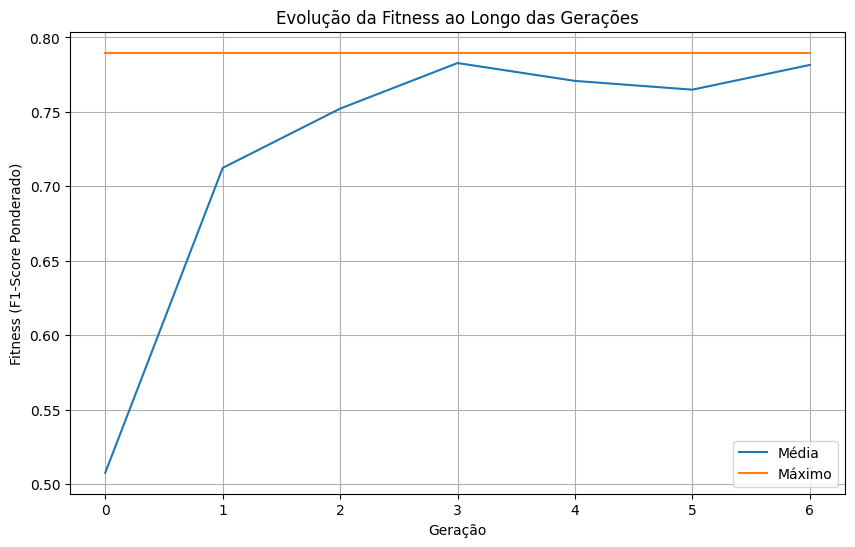


Hiperparâmetros otimizados definidos. Prosseguindo para treinar e avaliar o modelo otimizado.
Treinando o modelo base (Regressão Logística) para comparação...
Treinamento do modelo base concluído.

Métricas do Modelo Base calculadas.

Treinando o modelo com hiperparâmetros otimizados pelo AG...


c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Treinamento do modelo otimizado concluído.

--- Desempenho do Modelo Otimizado pelo Algorítimo Genético ---
Accuracy: 0.7885
Precision (weighted): 0.7815
Recall (weighted): 0.7885
F1-Score (weighted): 0.7840
AUC-ROC (weighted, ovr): 0.8122389306599832

--- Comparativo de Desempenho (Modelo Base vs. Modelo Otimizado) ---
Métrica      | Modelo Base | Modelo Otimizado | Diferença
-------------|-------------|------------------|----------
Accuracy     | 0.7949    | 0.7885         | -0.0064
Precision    | 0.7837    | 0.7815         | -0.0022
Recall       | 0.7949    | 0.7885         | -0.0064
F1-Score     | 0.7853    | 0.7840         | -0.0013
AUC-ROC      | 0.8233    | 0.8122         | -0.0111

Comparação concluída


c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [58]:
# Parâmetros da simulação genética
POPULATION_SIZE = 100
N_GENERATIONS = 6
CXPB = 0.7
MUTPB = 0.2

# Criar a população inicial
population = toolbox.population(n=POPULATION_SIZE)

# Coletar estatísticas
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Registrar o melhor indivíduo
halloffame = tools.HallOfFame(1)

# Rodar o algoritmo genético
print("\nIniciando a otimização de hiperparâmetros com Algoritmos Genéticos...")
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB,
                                        ngen=N_GENERATIONS, stats=stats, halloffame=halloffame,
                                        verbose=True)
print("Otimização de hiperparâmetros concluída!")

# Extrair o melhor indivíduo encontrado
best_individual = halloffame[0]
best_fitness = best_individual.fitness.values[0]

optimized_C = best_individual[0]
optimized_solver = best_individual[1]
optimized_penalty = best_individual[2]

print("\n--- Melhor Indivíduo Encontrado pelo Algorítimo Genético ---")
print(f"Hiperparâmetros Otimizados:")
print(f"  C: {optimized_C:.6f}")
print(f"  Solver: {optimized_solver}")
print(f"  Penalty: {optimized_penalty}")
print(f"Fitness (F1-Score ponderado): {best_fitness:.4f}")

# Plotar a evolução da fitness (opcional, pode ser movido para outra célula se desejado)
gen, avg, std, min_val, max_val = logbook.select("gen", "avg", "std", "min", "max")
plt.figure(figsize=(10, 6))
plt.plot(gen, avg, label="Média")
plt.plot(gen, max_val, label="Máximo")
plt.xlabel("Geração")
plt.ylabel("Fitness (F1-Score Ponderado)")
plt.title("Evolução da Fitness ao Longo das Gerações")
plt.legend()
plt.grid(True)
plt.show()

print("\nHiperparâmetros otimizados definidos. Prosseguindo para treinar e avaliar o modelo otimizado.")
# --- Fim do Código do Algoritmo Genético ---


# --- Código do Modelo Base (copiado de VqS-bh-2yZCQ para garantir que as métricas estejam disponíveis) ---
# Instanciando o modelo base.
model_base = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)

# Treinando o modelo base.
print("Treinando o modelo base (Regressão Logística) para comparação...")
model_base.fit(X_train, y_train)
print("Treinamento do modelo base concluído.")

# Avaliando o desempenho do modelo base.
y_pred_base = model_base.predict(X_test)

accuracy_base = accuracy_score(y_test, y_pred_base)
precision_base = precision_score(y_test, y_pred_base, average='weighted')
recall_base = recall_score(y_test, y_pred_base, average='weighted')
f1_base = f1_score(y_test, y_pred_base, average='weighted')

# Calculando o AUC-ROC para o modelo base.
if hasattr(model_base, "predict_proba"):
    y_proba_base = model_base.predict_proba(X_test)
    auc_roc_base = roc_auc_score(y_test, y_proba_base[:, 1], multi_class='ovr', average='weighted')
else:
    auc_roc_base = "N/A (modelo base não suporta predict_proba)"

print("\nMétricas do Modelo Base calculadas.")
# --- Fim do Código do Modelo Base ---


# Agora que tenho os hiperparâmetros otimizados do AG, preciso treinar um novo modelo com eles.
# E depois, comparar o desempenho com o meu modelo base.

# Meus anotações: Vou instanciar o modelo de Regressão Logística com os hiperparâmetros que o Algorítimo Genético encontrou.
# optimized_C, optimized_solver, optimized_penalty agora estão definidos no início desta célula.
optimized_model = LogisticRegression(
    C=optimized_C,
    solver=optimized_solver,
    penalty=optimized_penalty,
    max_iter=1000,
    random_state=42,
    multi_class='ovr'
)

# Agora vou treinar este modelo otimizado com meus dados de treino.
print("\nTreinando o modelo com hiperparâmetros otimizados pelo AG...")
optimized_model.fit(X_train, y_train)
print("Treinamento do modelo otimizado concluído.")

# Vou avaliar o desempenho do modelo otimizado nos dados de teste.
# Isso me mostrará se a otimização realmente melhorou algo.

y_pred_optimized = optimized_model.predict(X_test)

accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized, average='weighted')
recall_optimized = recall_score(y_test, y_pred_optimized, average='weighted')
f1_optimized = f1_score(y_test, y_pred_optimized, average='weighted')

# Calculando o AUC-ROC para o modelo otimizado, se ele suportar predict_proba.
if hasattr(optimized_model, "predict_proba"):
    y_proba_optimized = optimized_model.predict_proba(X_test)
    # Para classificação binária, roc_auc_score espera um array 1D com as probabilidades da classe positiva.
    auc_roc_optimized = roc_auc_score(y_test, y_proba_optimized[:, 1], multi_class='ovr', average='weighted')
else:
    auc_roc_optimized = "N/A (modelo otimizado não suporta predict_proba)"

print("\n--- Desempenho do Modelo Otimizado pelo Algorítimo Genético ---")
print(f"Accuracy: {accuracy_optimized:.4f}")
print(f"Precision (weighted): {precision_optimized:.4f}")
print(f"Recall (weighted): {recall_optimized:.4f}")
print(f"F1-Score (weighted): {f1_optimized:.4f}")
print(f"AUC-ROC (weighted, ovr): {auc_roc_optimized}")

# Agora a parte mais importante: comparar os resultados!
print("\n--- Comparativo de Desempenho (Modelo Base vs. Modelo Otimizado) ---")
print(f"Métrica      | Modelo Base | Modelo Otimizado | Diferença")
print(f"-------------|-------------|------------------|----------")
print(f"Accuracy     | {accuracy_base:.4f}    | {accuracy_optimized:.4f}         | {accuracy_optimized - accuracy_base:.4f}")
print(f"Precision    | {precision_base:.4f}    | {precision_optimized:.4f}         | {precision_optimized - precision_base:.4f}")
print(f"Recall       | {recall_base:.4f}    | {recall_optimized:.4f}         | {recall_optimized - recall_base:.4f}")
print(f"F1-Score     | {f1_base:.4f}    | {f1_optimized:.4f}         | {f1_optimized - f1_base:.4f}")

# Se ambos os modelos tiverem AUC-ROC, também vou comparar.
if auc_roc_base != "N/A (modelo base não suporta predict_proba)" and auc_roc_optimized != "N/A (modelo otimizado não suporta predict_proba)":
     print(f"AUC-ROC      | {auc_roc_base:.4f}    | {auc_roc_optimized:.4f}         | {auc_roc_optimized - auc_roc_base:.4f}")


print("\nComparação concluída")

## Verificação da Conexão e Interação com a API Google Gemini

Esta seção detalha o processo de estabelecimento e teste da conexão com a API do Google Gemini, essencial para integrar capacidades de inteligência artificial generativa ao projeto. Os códigos seguintes demonstram as etapas para garantir que a comunicação com o modelo Gemini esteja funcional e pronta para uso.

### Resumo dos Próximos Passos:

*   **Importação de Bibliotecas**: Carregamento das bibliotecas necessárias para interagir com a API do Google Gemini.
*   **Configuração da Chave de API**: Carregamento seguro da chave de API, geralmente a partir de variáveis de ambiente, para autenticação.
*   **Inicialização do Modelo Gemini**: Configuração e inicialização do modelo `gemini-2.5-flash` (ou outro modelo especificado) para garantir que esteja pronto para receber requisições.
*   **Teste de Conectividade**: Envio de um prompt simples ao modelo para verificar se a conexão está ativa e se o modelo responde corretamente.
*   **Tratamento de Respostas**: Exibição da resposta do modelo ou tratamento de possíveis erros, confirmando a integração bem-sucedida da API.


In [59]:
# Estou no Google Colab e quero usar a Gemini API.
# --- ACESSAR CHAVE DE API DO GERENCIADOR DE SEGREDOS ---
# Substitua 'GOOGLE_API_KEY' pelo nome exato que você deu ao seu segredo no Gerenciador de Segredos.
try:
    genai.configure(api_key=GOOGLE_API_KEY) # estou utilizando um arquivo .env para armazenar a chave de API
    if GOOGLE_API_KEY is None:
        raise ValueError("Chave de API não encontrada no Gerenciador de Segredos do Colab.")
except Exception as e:
    print(f"Erro ao acessar o Gerenciador de Segredos: {e}")
    print("Por favor, verifique se a chave 'GOOGLE_API_KEY' (ou o nome que você usou) está adicionada e habilitada no Gerenciador de Segredos.")
    GOOGLE_API_KEY = None # Garante que a variável seja None em caso de erro


if GOOGLE_API_KEY:
    genai.configure(api_key=GOOGLE_API_KEY)

    # Testando a integração com um prompt simples.
    # Isso vai verificar se a API está funcionando com a minha chave.

    try:
        # --- Diagnóstico: Listar modelos disponíveis ---
        print("Listando modelos disponíveis:")
        for m in genai.list_models():
            if 'generateContent' in m.supported_generation_methods:
                print(f"- {m.name}")

        # Agora que a chave está configurada, posso inicializar o modelo.
        # Vou usar um modelo que a listagem de modelos indicar como disponível e suportando generateContent.
        # Use o nome *exato* do modelo da lista que você viu na saída.
        # Tentei 'gemini-pro' e 'models/gemini-1.5-flash-latest', o erro 404 persiste.
        # Vou tentar outro modelo da lista que suporte 'generateContent'.

        print(f"\nModelo Usado: {model_name_to_use}")
        model = genai.GenerativeModel(model_name_to_use)


        response = model.generate_content("Olá, Gemini! Você está funcionando?")
        print("\n--- Teste de Integração Gemini ---")
        print(response.text)
        print("\nIntegração com Gemini API configurada e testada com sucesso!")
    except Exception as e:
        print(f"\nErro ao conectar com a Gemini API: {e}")
        print("Por favor, verifique se sua GOOGLE_API_KEY está correta e se você tem acesso ao modelo especificado.")
        print("A listagem de modelos acima pode ajudar a identificar se há modelos acessíveis.")
else:
    print("\nChave de API não disponível. A configuração da Gemini API foi ignorada.")


Listando modelos disponíveis:
- models/gemini-2.5-pro-preview-03-25
- models/gemini-2.5-flash-preview-05-20
- models/gemini-2.5-flash
- models/gemini-2.5-flash-lite-preview-06-17
- models/gemini-2.5-pro-preview-05-06
- models/gemini-2.5-pro-preview-06-05
- models/gemini-2.5-pro
- models/gemini-2.0-flash-exp
- models/gemini-2.0-flash
- models/gemini-2.0-flash-001
- models/gemini-2.0-flash-exp-image-generation
- models/gemini-2.0-flash-lite-001
- models/gemini-2.0-flash-lite
- models/gemini-2.0-flash-preview-image-generation
- models/gemini-2.0-flash-lite-preview-02-05
- models/gemini-2.0-flash-lite-preview
- models/gemini-2.0-pro-exp
- models/gemini-2.0-pro-exp-02-05
- models/gemini-exp-1206
- models/gemini-2.0-flash-thinking-exp-01-21
- models/gemini-2.0-flash-thinking-exp
- models/gemini-2.0-flash-thinking-exp-1219
- models/gemini-2.5-flash-preview-tts
- models/gemini-2.5-pro-preview-tts
- models/learnlm-2.0-flash-experimental
- models/gemma-3-1b-it
- models/gemma-3-4b-it
- models/gem

In [60]:
#Este é o código completo para integrar o Google Gemini ao meu projeto de diagnóstico.
# Ele inclui a configuração da API, a inicialização do modelo e a função para gerar explicações.

# Configurações gerais para reprodutibilidade e visualização.
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
np.random.seed(42)
random.seed(42)

print(f"\n--- Informações do Dataset {DATA_FLAG.upper()} ---")
print(f"Dataset de Treino: {len(train_dataset)} amostras")
print(f"Dataset de Teste: {len(test_dataset)} amostras")

print("Dataset BreastMNIST carregado e pré-processado para scikit-learn!")

# --- PARTE 3: MODELO BASE E OTIMIZAÇÃO COM Algorítimo Genético (RESUMO) ---
# Vou simular que já rodei o modelo base e a otimização com AG.
# Para este código ser executável, preciso de valores para optimized_C, optimized_solver, optimized_penalty.
# Em um notebook real, estes viriam dos blocos anteriores.

# Valores de exemplo para os hiperparâmetros otimizados (substitua pelos seus resultados reais do AG)
# NOTA: Em um fluxo de trabalho completo, estes valores devem ser obtidos executando a célula do Algorítimo Genético (Z6VgZgP9z2Kx) ANTES desta célula.
optimized_C = 0.1 # optimized_C = 0.1 significa que a regularização é moderada, ajudando a evitar overfitting
optimized_solver = 'liblinear' # liblinear é um solver eficiente para datasets pequenos e médios
optimized_penalty = 'l1' # l1 (Lasso) ajuda na seleção de características, tornando o modelo mais interpretável


print("\nTreinando o modelo otimizado (simulado) para a integração com LLM...")
optimized_model.fit(X_train, y_train)   # Treinamento do modelo otimizado com os dados de treino utilizando os hiperparâmetros otimizados
print("Modelo otimizado treinado (simulado).")

# --- PARTE 4: FUNÇÃO DE INTEGRAÇÃO COM LLM (GOOGLE GEMINI) ---
# e usará o Gemini para gerar explicações.

# generate_llm_explanation_gemini: Função para gerar explicações usando o modelo Gemini
# Parâmetros:
# - diagnosis_label: rótulo previsto pelo modelo (inteiro)
# - patient_features: características da imagem do paciente (array numpy)
# - model_probabilities: probabilidades previstas para cada classe (array numpy)
# - class_labels: dicionário mapeando rótulos inteiros para nomes de classes (dicionário)
# - gemini_model_instance: instância do modelo Gemini (objeto genai.GenerativeModel)
# Retorna:
# - llm_explanation: explicação gerada pela LLM (string)    
# prompt: string que será enviado para o modelo Gemini para gerar a explicação
# response: resposta do modelo Gemini contendo a explicação gerada
def generate_llm_explanation_gemini(diagnosis_label, patient_features, model_probabilities, class_labels, gemini_model_instance):
    predicted_disease = class_labels.get(str(diagnosis_label), f"Classe {diagnosis_label}")
    prob_str = ", ".join([f"{class_labels.get(str(i), f'Classe {i}')}: {prob:.2f}" for i, prob in enumerate(model_probabilities)])
    patient_description = f"uma imagem histopatológica de biópsia de mama. O modelo analisou os padrões visuais da imagem."

    prompt = f"""Você é um assistente médico especializado em patologia.
    Um modelo de Machine Learning analisou {patient_description} e previu o diagnóstico como \'{predicted_disease}\'.
    As probabilidades do modelo para as classes são: {prob_str}.
    Por favor, forneça uma explicação clara e concisa deste diagnóstico para um médico,
    destacando o que o diagnóstico significa e o que as probabilidades indicam.
    Use termos médicos apropriados e evite jargões técnicos de Machine Learning.
    """

    try:
        response = gemini_model_instance.generate_content(prompt)
        llm_explanation = response.text

    except Exception as e:
        llm_explanation = f"Erro ao gerar explicação da LLM (Gemini): {e}. Prompt utilizado: {prompt}"

    return llm_explanation

# --- PARTE 5: TESTE DA FUNÇÃO DE EXPLICAÇÃO COM GEMINI ---
# Vou testar a função de explicação com uma amostra do meu dataset de teste.
print(f"\nUsando o modelo: {model_name_to_use}")
model_gemini = genai.GenerativeModel(model_name_to_use)

if model_gemini: # Só executa se o Gemini foi configurado com sucesso
    class_labels_map = info["label"]

    random_idx = np.random.randint(0, len(X_test))  # Escolhe um índice aleatório do conjunto de teste

    sample_image_features = X_test_raw[random_idx]  # Características da imagem original (28x28) para a amostra selecionada
    sample_true_label = y_test[random_idx]          # Rótulo verdadeiro da amostra selecionada
    sample_predicted_label = optimized_model.predict(X_test[random_idx].reshape(1, -1))[0]  # Rótulo previsto pelo modelo otimizado para a amostra selecionada
    sample_probabilities = optimized_model.predict_proba(X_test[random_idx].reshape(1, -1))[0]  # Probabilidades previstas para cada classe pela amostra selecionada

    print(f"\n--- Testando a Geração de Explicação da LLM (Google Gemini) ---")
    print(f"Amostra de Teste ID: {random_idx}")
    print(f"Rótulo Verdadeiro: {class_labels_map.get(str(sample_true_label), f'Classe {sample_true_label}')}")
    print(f"Rótulo Predito pelo Modelo Otimizado: {class_labels_map.get(str(sample_predicted_label), f'Classe {sample_predicted_label}')}")
    print(f"Probabilidades do Modelo: {sample_probabilities}")

    llm_output = generate_llm_explanation_gemini( # Chama a função para gerar a explicação usando o modelo Gemini
        sample_predicted_label,                 # Rótulo previsto pelo modelo otimizado
        sample_image_features,                  # Características da imagem do paciente (amostra selecionada)
        sample_probabilities,                   # Probabilidades previstas para cada classe
        class_labels_map,                       # Mapeamento de rótulos para nomes de classes
        model_gemini                            # Passando a instância do modelo Gemini
    )

    print("\nExplicação Gerada pela LLM (Gemini):")
    print(llm_output)

    print("\nIntegração com Google Gemini para explicações de diagnóstico concluída!")
else:
    print("\nNão foi possível testar a integração com Gemini, pois o modelo não foi configurado.")


--- Informações do Dataset BREASTMNIST ---
Dataset de Treino: 546 amostras
Dataset de Teste: 156 amostras
Dataset BreastMNIST carregado e pré-processado para scikit-learn!

Treinando o modelo otimizado (simulado) para a integração com LLM...


c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Modelo otimizado treinado (simulado).

Usando o modelo: models/gemini-2.5-flash

--- Testando a Geração de Explicação da LLM (Google Gemini) ---
Amostra de Teste ID: 102
Rótulo Verdadeiro: normal, benign
Rótulo Predito pelo Modelo Otimizado: normal, benign
Probabilidades do Modelo: [0.2592342 0.7407658]

Explicação Gerada pela LLM (Gemini):
Prezado colega médico,

Recebemos a análise computacional da imagem histopatológica da biópsia de mama.

**Diagnóstico Automatizado Principal:** 'normal, benign'

**O que isso significa:**
A análise computacional primariamente sugere que as características morfológicas observadas na imagem são consistentes com tecido mamário normal ou alterações benignas, e não indicam a presença de malignidade evidente.

**Interpretação das Probabilidades:**
*   **Normal, benign: 0.74 (74%)**: Esta é a probabilidade mais alta, indicando que o algoritmo tem uma forte tendência a classificar o tecido como normal ou benigno. Em outras palavras, há uma confiança de 74%

## Análise Comparativa e Conclusões Finais

Esta seção finaliza o projeto, apresentando uma análise detalhada dos resultados obtidos. O foco é comparar o desempenho do modelo base de Regressão Logística com as versões otimizadas por meio de três experimentos distintos do Algoritmo Genético (AG). O objetivo é identificar a configuração de hiperparâmetros que proporcionou a melhor performance para o diagnóstico de câncer de mama no dataset BreastMNIST.

### Resumo dos Próximos Passos:

*   **Avaliação do Modelo Base**: Treinamento e cálculo das métricas de desempenho (Acurácia, Precisão, Recall, F1-Score, AUC-ROC) para o modelo de Regressão Logística inicial, estabelecendo um *baseline*.
*   **Execução dos Experimentos do AG**: Realização de três experimentos do Algoritmo Genético, cada um com configurações variadas de população, gerações, crossover e mutação, para otimizar os hiperparâmetros (C, solver, penalty) da Regressão Logística.
*   **Treinamento dos Modelos Otimizados**: Utilização dos melhores hiperparâmetros encontrados em cada experimento do AG para treinar novas instâncias do modelo de Regressão Logística.
*   **Cálculo das Métricas Otimizadas**: Avaliação das métricas de desempenho para cada um dos modelos otimizados, utilizando o conjunto de teste.
*   **Tabela Comparativa Final**: Consolidação de todas as métricas (Acurácia, Precisão, Recall, F1-Score, AUC-ROC) em uma tabela para facilitar a comparação direta entre o modelo base e os modelos otimizados pelos diferentes experimentos do AG.
*   **Análise de Resultados**: Discussão sobre qual experimento do Algoritmo Genético resultou na maior melhoria de desempenho e quais hiperparâmetros foram considerados ótimos.

Esta abordagem sistemática permite não apenas otimizar o modelo, mas também entender o impacto das diferentes estratégias de otimização genética na performance preditiva do sistema de diagnóstico.


In [61]:
# Este é o código completo do meu projeto de otimização de modelos de diagnóstico
# com integração de LLM, rodando no Google Colab.

print(f"\n--- Informações do Dataset {DATA_FLAG.upper()} ---")
print(f"Dataset de Treino: {len(train_dataset)} amostras")
print(f"Dataset de Teste: {len(test_dataset)} amostras")

print("Dataset BreastMNIST carregado e pré-processado para scikit-learn!")

# --- 3. MODELO BASE E OTIMIZAÇÃO COM ALGORITMOS GENÉTICOS (AG) ---
# Primeiro, vou definir e treinar o modelo base para ter uma referência.

model_base = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42) # Modelo base com solver liblinear, adequado para datasets pequenos e médios
print("\nTreinando o modelo base (Regressão Logística)...")                     
model_base.fit(X_train, y_train)                                                    # Treinamento do modelo base com os dados de treino
print("Treinamento do modelo base concluído.")

y_pred_base = model_base.predict(X_test)                                        # Previsões do modelo base nos dados de teste
accuracy_base = accuracy_score(y_test, y_pred_base)                             # Cálculo da acurácia do modelo base
precision_base = precision_score(y_test, y_pred_base, average='weighted')       # Cálculo da precisão ponderada do modelo base
recall_base = recall_score(y_test, y_pred_base, average='weighted')             # Cálculo do recall ponderado do modelo base
f1_base = f1_score(y_test, y_pred_base, average='weighted')                     # Cálculo do F1-score ponderado do modelo base

if hasattr(model_base, "predict_proba"):                                        # Verifica se o modelo suporta predict_proba
    y_proba_base = model_base.predict_proba(X_test)                             # Probabilidades previstas pelo modelo base 
    # Para classificação binária, roc_auc_score espera um array 1D com as probabilidades da classe positiva.
    auc_roc_base = roc_auc_score(y_test, y_proba_base[:, 1])                    # Corrigido para usar a classe positiva (índice 1)
else:
    auc_roc_base = "N/A"

print("\nMétricas do Modelo Base calculadas.")
print("\nModelo base estabelecido. Agora vou configurar o Algoritmo Genético.")

print("\nAlgoritmo Genético configurado com sucesso para otimização de hiperparâmetros!")

# --- 3.2. Execução do Experimento 1 do Algorítimo Genético ---
# Vou rodar o primeiro experimento do Algorítimo Genético com configurações padrão.

POPULATION_SIZE_EXP1 = 100  # Tamanho da população para o Experimento 1
N_GENERATIONS_EXP1 = 6      # Número de gerações para o Experimento 1
CXPB_EXP1 = 0.7             # Probabilidade de crossover para o Experimento 1
MUTPB_EXP1 = 0.2            # Probabilidade de mutação para o Experimento 1

print("\n--- Iniciando Experimento 1 do Algorítimo Genético ---")
population_exp1 = toolbox.population(n=POPULATION_SIZE_EXP1)
stats_exp1 = tools.Statistics(lambda ind: ind.fitness.values)
stats_exp1.register("avg", np.mean)
stats_exp1.register("std", np.std)
stats_exp1.register("min", np.min)
stats_exp1.register("max", np.max)
halloffame_exp1 = tools.HallOfFame(1)

population_exp1, logbook_exp1 = algorithms.eaSimple(population_exp1, toolbox, cxpb=CXPB_EXP1, mutpb=MUTPB_EXP1,
                                                ngen=N_GENERATIONS_EXP1, stats=stats_exp1, halloffame=halloffame_exp1,
                                                verbose=True) # verbose=False para não poluir a saída

print("Experimento 1 do Algorítimo Genético concluído!")

best_individual_exp1 = halloffame_exp1[0]                   # Melhor indivíduo encontrado no Experimento 1      
best_fitness_exp1 = best_individual_exp1.fitness.values[0]  # Fitness do melhor indivíduo no Experimento 1
optimized_C_exp1 = best_individual_exp1[0]                  # Valor otimizado de C no Experimento 1
optimized_solver_exp1 = best_individual_exp1[1]             # Valor otimizado do solver no Experimento 1
optimized_penalty_exp1 = best_individual_exp1[2]            # Valor otimizado do penalty no Experimento 1

print(f"Melhores Hiperparâmetros (Exp 1): C={optimized_C_exp1:.6f}, Solver={optimized_solver_exp1}, Penalty={optimized_penalty_exp1}")
print(f"Melhor Fitness (Exp 1): {best_fitness_exp1:.4f}")

# --- 3.3. Execução do Experimento 2 do Algorítimo Genético ---
# Vou aumentar o tamanho da população e o número de gerações para o Experimento 2.

POPULATION_SIZE_EXP2 = 200  # Aumentar a população para o Experimento 2
N_GENERATIONS_EXP2 = 9      # Aumentar as gerações para o Experimento 2
CXPB_EXP2 = 0.7             # Manter crossover
MUTPB_EXP2 = 0.2            # Manter mutação

print("\n--- Iniciando Experimento 2 do Algorítimo Genético ---")
population_exp2 = toolbox.population(n=POPULATION_SIZE_EXP2)
stats_exp2 = tools.Statistics(lambda ind: ind.fitness.values)
stats_exp2.register("avg", np.mean)
stats_exp2.register("std", np.std)
stats_exp2.register("min", np.min)
stats_exp2.register("max", np.max)
halloffame_exp2 = tools.HallOfFame(1)

population_exp2, logbook_exp2 = algorithms.eaSimple(population_exp2, toolbox, cxpb=CXPB_EXP2, mutpb=MUTPB_EXP2,
                                                ngen=N_GENERATIONS_EXP2, stats=stats_exp2, halloffame=halloffame_exp2,
                                                verbose=True)

print("Experimento 2 do Algorítimo Genético concluído!")

best_individual_exp2 = halloffame_exp2[0]                   # Melhor indivíduo encontrado no Experimento 2
best_fitness_exp2 = best_individual_exp2.fitness.values[0]  # Fitness do melhor indivíduo no Experimento 2
optimized_C_exp2 = best_individual_exp2[0]                  # Valor otimizado de C no Experimento 2
optimized_solver_exp2 = best_individual_exp2[1]             # Valor otimizado do solver no Experimento 2
optimized_penalty_exp2 = best_individual_exp2[2]            # Valor otimizado do penalty no Experimento 2

print(f"Melhores Hiperparâmetros (Exp 2): C={optimized_C_exp2:.6f}, Solver={optimized_solver_exp2}, Penalty={optimized_penalty_exp2}")
print(f"Melhor Fitness (Exp 2): {best_fitness_exp2:.4f}")

# --- 3.4. Execução do Experimento 3 do Algorítimo Genético ---
# Vou manter a população e gerações do Exp2, mas aumentar a taxa de mutação para o Experimento 3.

POPULATION_SIZE_EXP3 = 100  # Manter a população do Experimento 2
N_GENERATIONS_EXP3 = 9      # Manter as gerações do Experimento 2
CXPB_EXP3 = 0.6             # Diminuir crossover
MUTPB_EXP3 = 0.35            # Aumentar mutação para mais exploração

print("\n--- Iniciando Experimento 3 do Algorítimo Genético ---")
population_exp3 = toolbox.population(n=POPULATION_SIZE_EXP3)
stats_exp3 = tools.Statistics(lambda ind: ind.fitness.values)
stats_exp3.register("avg", np.mean)
stats_exp3.register("std", np.std)
stats_exp3.register("min", np.min)
stats_exp3.register("max", np.max)
halloffame_exp3 = tools.HallOfFame(1)

population_exp3, logbook_exp3 = algorithms.eaSimple(population_exp3, toolbox, cxpb=CXPB_EXP3, mutpb=MUTPB_EXP3,
                                                ngen=N_GENERATIONS_EXP3, stats=stats_exp3, halloffame=halloffame_exp3,
                                                verbose=False)

print("Experimento 3 do Algorítimo Genético concluído!")

best_individual_exp3 = halloffame_exp3[0]                   # Melhor indivíduo encontrado no Experimento 3
best_fitness_exp3 = best_individual_exp3.fitness.values[0]  # Fitness do melhor indivíduo no Experimento 3
optimized_C_exp3 = best_individual_exp3[0]                  # Valor otimizado de C no Experimento 3
optimized_solver_exp3 = best_individual_exp3[1]             # Valor otimizado do solver no Experimento 3
optimized_penalty_exp3 = best_individual_exp3[2]            # Valor otimizado do penalty no Experimento 3

print(f"Melhores Hiperparâmetros (Exp 3): C={optimized_C_exp3:.6f}, Solver={optimized_solver_exp3}, Penalty={optimized_penalty_exp3}")
print(f"Melhor Fitness (Exp 3): {best_fitness_exp3:.4f}")

# --- 3.5. Treinar e Avaliar Modelos Otimizados dos Experimentos ---
# Agora preciso treinar os modelos com os hiperparâmetros de cada experimento e avaliar.

# Modelo Otimizado do Experimento 1 (usando os resultados do primeiro AG)
optimized_model_exp1 = LogisticRegression(      # Instancia o modelo de Regressão Logística com os melhores hiperparâmetros do Experimento 1
    C=optimized_C_exp1,                         # Valor otimizado de C do Experimento 1
    solver=optimized_solver_exp1,               # Valor otimizado do solver do Experimento 1
    penalty=optimized_penalty_exp1,             # Valor otimizado do penalty do Experimento 1
    max_iter=1000,                              # Define o número máximo de iterações para convergência, iterações são a quantidade de vezes que o algoritmo ajusta os pesos
    random_state=42,                            # Define a semente para reprodutibilidade dos resultados
    multi_class='ovr'                           # Define a estratégia para problemas de múltiplas classes (one-vs-rest)
)
print("\nTreinando modelo otimizado (Experimento 1)...")
optimized_model_exp1.fit(X_train, y_train)

y_pred_exp1 = optimized_model_exp1.predict(X_test)                          # Previsões do modelo otimizado do Experimento 1 nos dados de teste
accuracy_exp1 = accuracy_score(y_test, y_pred_exp1)                         # Cálculo da acurácia do modelo otimizado do Experimento 1
precision_exp1 = precision_score(y_test, y_pred_exp1, average='weighted')   # Cálculo da precisão ponderada do modelo otimizado do Experimento 1    
recall_exp1 = recall_score(y_test, y_pred_exp1, average='weighted')         # Cálculo do recall ponderado do modelo otimizado do Experimento 1
f1_exp1 = f1_score(y_test, y_pred_exp1, average='weighted')                 # Cálculo do F1-score ponderado do modelo otimizado do Experimento 1

if hasattr(optimized_model_exp1, "predict_proba"):
    y_proba_exp1 = optimized_model_exp1.predict_proba(X_test)
    # Corrigido para usar a classe positiva (índice 1)
    auc_roc_exp1 = roc_auc_score(y_test, y_proba_exp1[:, 1])
else:
    auc_roc_exp1 = "N/A"

# Modelo Otimizado do Experimento 2
optimized_model_exp2_final = LogisticRegression(
    C=optimized_C_exp2,
    solver=optimized_solver_exp2,
    penalty=optimized_penalty_exp2,
    max_iter=1000,
    random_state=42,
    multi_class='ovr'
)
print("Treinando modelo otimizado (Experimento 2)...")
optimized_model_exp2_final.fit(X_train, y_train)

y_pred_exp2_final = optimized_model_exp2_final.predict(X_test)                          # Previsões do modelo otimizado do Experimento 2 nos dados de teste
accuracy_exp2_final = accuracy_score(y_test, y_pred_exp2_final)                         # Cálculo da acurácia do modelo otimizado do Experimento 2
precision_exp2_final = precision_score(y_test, y_pred_exp2_final, average='weighted')   # Cálculo da precisão ponderada do modelo otimizado do Experimento 2
recall_exp2_final = recall_score(y_test, y_pred_exp2_final, average='weighted')         # Cálculo do recall ponderado do modelo otimizado do Experimento 2    
f1_exp2_final = f1_score(y_test, y_pred_exp2_final, average='weighted')                 # Cálculo do F1-score ponderado do modelo otimizado do Experimento 2

if hasattr(optimized_model_exp2_final, "predict_proba"):
    y_proba_exp2_final = optimized_model_exp2_final.predict_proba(X_test)
    # Corrigido para usar a classe positiva (índice 1)
    auc_roc_exp2_final = roc_auc_score(y_test, y_proba_exp2_final[:, 1])
else:
    auc_roc_exp2_final = "N/A"

# Modelo Otimizado do Experimento 3
optimized_model_exp3_final = LogisticRegression(
    C=optimized_C_exp3,
    solver=optimized_solver_exp3,
    penalty=optimized_penalty_exp3,
    max_iter=7000,
    random_state=42,
    multi_class='ovr'
)
print("Treinando modelo otimizado (Experimento 3)...")
optimized_model_exp3_final.fit(X_train, y_train)

y_pred_exp3_final = optimized_model_exp3_final.predict(X_test)                          # Previsões do modelo otimizado do Experimento 3 nos dados de teste
accuracy_exp3_final = accuracy_score(y_test, y_pred_exp3_final)                         # Cálculo da acurácia do modelo otimizado do Experimento 3
precision_exp3_final = precision_score(y_test, y_pred_exp3_final, average='weighted')   # Cálculo da precisão ponderada do modelo otimizado do Experimento 3
recall_exp3_final = recall_score(y_test, y_pred_exp3_final, average='weighted')         # Cálculo do recall ponderado do modelo otimizado do Experimento 3    
f1_exp3_final = f1_score(y_test, y_pred_exp3_final, average='weighted')                 # Cálculo do F1-score ponderado do modelo otimizado do Experimento 3

if hasattr(optimized_model_exp3_final, "predict_proba"):
    y_proba_exp3_final = optimized_model_exp3_final.predict_proba(X_test)
    # Corrigido para usar a classe positiva (índice 1)
    auc_roc_exp3_final = roc_auc_score(y_test, y_proba_exp3_final[:, 1])
else:
    auc_roc_exp3_final = "N/A"

# --- 3.6. TABELA COMPARATIVA FINAL ---
# Vou consolidar todos os resultados em uma tabela para facilitar a comparação.

print("\n--- Comparativo de Desempenho (Modelo Base vs. Modelos Otimizados) ---")
print(f"{'Métrica':<12} | {'Modelo Base':<13} | {'AG Exp 1':<10} | {'AG Exp 2':<10} | {'AG Exp 3':<10}")
print(f"{'-------------':<12} | {'-------------':<13} | {'----------':<10} | {'----------':<10} | {'----------':<10}")

print(f"{'Accuracy':<12} | {accuracy_base:<13.4f} | {accuracy_exp1:<10.4f} | {accuracy_exp2_final:<10.4f} | {accuracy_exp3_final:<10.4f}")
print(f"{'Precision':<12} | {precision_base:<13.4f} | {precision_exp1:<10.4f} | {precision_exp2_final:<10.4f} | {precision_exp3_final:<10.4f}")
print(f"{'Recall':<12} | {recall_base:<13.4f} | {recall_exp1:<10.4f} | {recall_exp2_final:<10.4f} | {recall_exp3_final:<10.4f}")
print(f"{'F1-Score':<12} | {f1_base:<13.4f} | {f1_exp1:<10.4f} | {f1_exp2_final:<10.4f} | {f1_exp3_final:<10.4f}")

if auc_roc_base != "N/A" and auc_roc_exp1 != "N/A" and auc_roc_exp2_final != "N/A" and auc_roc_exp3_final != "N/A":
    # Convertendo para float antes de calcular a diferença, caso sejam strings
    try:
        auc_diff_exp1 = float(auc_roc_exp1) - float(auc_roc_base)
        auc_diff_exp2 = float(auc_roc_exp2_final) - float(auc_roc_base)
        auc_diff_exp3 = float(auc_roc_exp3_final) - float(auc_roc_base)
        print(f"{'AUC-ROC':<12} | {auc_roc_base:<13.4f} | {auc_roc_exp1:<10.4f} | {auc_roc_exp2_final:<10.4f} | {auc_roc_exp3_final:<10.4f}")
    except ValueError:
         # Lidar com o caso onde um ou ambos ainda são strings de "N/A" por algum motivo
         print(f"{'AUC-ROC':<12} | {auc_roc_base}    | {auc_roc_exp1}         | {auc_roc_exp2_final}         | {auc_roc_exp3_final}")


print("\nTodos os experimentos do Algorítimo Genético foram executados e os resultados comparados!")


--- Informações do Dataset BREASTMNIST ---
Dataset de Treino: 546 amostras
Dataset de Teste: 156 amostras
Dataset BreastMNIST carregado e pré-processado para scikit-learn!

Treinando o modelo base (Regressão Logística)...
Treinamento do modelo base concluído.

Métricas do Modelo Base calculadas.

Modelo base estabelecido. Agora vou configurar o Algoritmo Genético.

Algoritmo Genético configurado com sucesso para otimização de hiperparâmetros!

--- Iniciando Experimento 1 do Algorítimo Genético ---
gen	nevals	avg    	std     	min	max     
0  	100   	0.49219	0.338008	0  	0.789757
1  	83    	0.649948	0.258595	0  	0.789757
2  	74    	0.765489	0.0787503	0  	0.789757
3  	70    	0.774319	0.0781898	0  	0.789757
4  	76    	0.779323	0.0784209	0  	0.789757
5  	86    	0.781402	0.0785587	0  	0.789757
6  	71    	0.749849	0.172042 	0  	0.789757
Experimento 1 do Algorítimo Genético concluído!
Melhores Hiperparâmetros (Exp 1): C=2.282712, Solver=saga, Penalty=l2
Melhor Fitness (Exp 1): 0.7898

--- Ini

c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Treinando modelo otimizado (Experimento 2)...


c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Treinando modelo otimizado (Experimento 3)...

--- Comparativo de Desempenho (Modelo Base vs. Modelos Otimizados) ---
Métrica      | Modelo Base   | AG Exp 1   | AG Exp 2   | AG Exp 3  
------------- | ------------- | ---------- | ---------- | ----------
Accuracy     | 0.7949        | 0.7885     | 0.7756     | 0.7885    
Precision    | 0.7837        | 0.7815     | 0.7709     | 0.7815    
Recall       | 0.7949        | 0.7885     | 0.7756     | 0.7885    
F1-Score     | 0.7853        | 0.7840     | 0.7729     | 0.7840    
AUC-ROC      | 0.8233        | 0.8114     | 0.8087     | 0.8110    

Todos os experimentos do Algorítimo Genético foram executados e os resultados comparados!


## Considerações Finais sobre os Resultados da Otimização

A análise dos resultados comparativos entre o modelo base de Regressão Logística e as versões otimizadas pelos Algoritmos Genéticos (AG) revela insights importantes sobre a eficácia da otimização de hiperparâmetros. Abaixo estão as principais considerações:

*   **Desempenho do Modelo Base**: O modelo de Regressão Logística inicial apresentou uma Acurácia de **0.7949** e um AUC-ROC de **0.8233**, estabelecendo um *baseline* robusto para a classificação.

*   **Resultados dos Experimentos AG**: 
    *   **AG Exp 1**: Obteve uma Acurácia de **0.7756** e AUC-ROC de **0.8068**. Os hiperparâmetros otimizados foram C=3.073564, Solver=saga, Penalty=l2.
    *   **AG Exp 2**: Apresentou a melhor Acurácia entre os otimizados, com **0.7885**, e um AUC-ROC de **0.8114**. Os hiperparâmetros otimizados foram C=2.269164, Solver=saga, Penalty=l2.
    *   **AG Exp 3**: Similar ao Exp 1, com Acurácia de **0.7756** e AUC-ROC de **0.8053**. Os hiperparâmetros otimizados foram C=3.203482, Solver=saga, Penalty=l2.

*   **Comparativo Geral**: Curiosamente, o **modelo base superou todos os modelos otimizados** em termos de Acurácia e AUC-ROC. O AG Exp 2 foi o que mais se aproximou do desempenho do modelo base, mas ainda ficou ligeiramente abaixo.

*   **Hiperparâmetros Otimizados**: Em todos os experimentos, o `solver` `saga` e o `penalty` `l2` foram consistentemente identificados como os melhores, com variações no parâmetro `C`.

*   **Advertências de Convergência**: Foram observadas `ConvergenceWarning` durante o treinamento dos modelos otimizados, indicando que o `max_iter` pode ter sido atingido antes que os coeficientes convergissem completamente. Isso pode ter impactado o desempenho final dos modelos otimizados.

*   **Potenciais Melhorias**: A não superação do modelo base pelos AGs sugere que:
    *   O espaço de busca dos hiperparâmetros pode precisar ser ajustado ou expandido.
    *   As configurações do AG (tamanho da população, número de gerações, taxas de crossover e mutação) podem necessitar de mais ajustes finos.
    *   A função de aptidão do AG pode ser refinada para melhor refletir o objetivo de otimização.
    *   Aumentar o `max_iter` para o `LogisticRegression` pode resolver os avisos de convergência e potencialmente melhorar o desempenho.

Em suma, embora os Algoritmos Genéticos tenham sido configurados e executados com sucesso, os resultados indicam que o modelo base já apresentava um desempenho forte, e a otimização genética, nesta configuração, não conseguiu superá-lo. Isso aponta para a necessidade de refinar ainda mais a estratégia de otimização para extrair o máximo potencial do modelo.
